In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=200):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (int): Number of nodes in the hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=80, fc2_units=80, fc3_units=40):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [4]:
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim

BUFFER_SIZE = int(3e4)      # replay buffer size
BATCH_SIZE = 512            # minibatch size
GAMMA = 0.99                # discount factor
TAU = 1e-2                  # for soft update of target parameters
LR_ACTOR = 1e-3             # learning rate of the actor 
LR_CRITIC = 3e-3            # learning rate of the critic
UPDATE_EVERY = 4            # Update weights after this amount of steps
SUCCESS_REPLAY_FACTOR = 4   # Add successful actions to buffer multiple times
MAIN_GAME_REPLAY_FACTOR = 2 # Add experiences after 1st hit multiple times to buffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.step_counter = 0
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, main_game):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.step_counter += 1
        
        self.memory.add(state, action, reward, next_state, done)
        
        # If this is a successful move, add to replay memory multiple times
        if reward > 0.0:
            for i in range(SUCCESS_REPLAY_FACTOR - 1):
                self.memory.add(state, action, reward, next_state, done)
        # If we are in the main game (after 1st hit), add to replay memory multiple times
        elif main_game:
            for k in range(MAIN_GAME_REPLAY_FACTOR - 1):
                self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if self.step_counter == UPDATE_EVERY:
            self.step_counter = 0
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        return np.clip(actions, -1, 1)

    def learn(self, experiences, gamma):
        """Updates policy and value parameters using given batch of experience tuples.
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # update critic 
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update actor 
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # update target networks
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        b_size = min(len(self.memory), self.batch_size)
        experiences = random.sample(self.memory, k=b_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
agent = Agent(state_size=48, action_size=4, random_seed=10)

Episode 500	Average Score: 0.01	Episode Score: 0.09
Episode 1000	Average Score: 0.01	Episode Score: 0.00
Episode 1500	Average Score: 0.04	Episode Score: 0.00
Episode 2000	Average Score: 0.04	Episode Score: 0.10
Episode 2500	Average Score: 0.15	Episode Score: 0.10
Environment solved in 2605 episodes	Average Score: 0.51


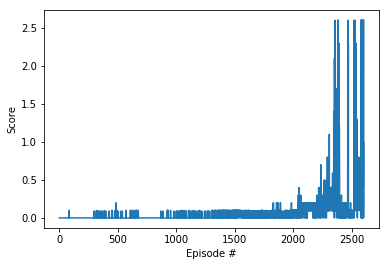

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def ddpg(n_episodes=10000, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations.flatten()
        episode_scores = np.zeros(num_agents)
        main_game = False
        for t in range(max_t):
            action = agent.act(state)
            action_per_agent = action.reshape((2,2))
            env_info = env.step(action_per_agent)[brain_name]
            next_state = env_info.vector_observations.flatten()
            rewards = np.array(env_info.rewards)    
            done = np.any(env_info.local_done)
            agent.step(state, action, rewards.sum(), next_state, done, main_game)
            # The first time we hit the ball, we move into the main game.
            if rewards.sum() > 0.0:
                main_game = True
            state = next_state
            episode_scores += rewards
            if done:
                break
        episode_score = np.max(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode Score: {:.2f}'\
              .format(i_episode, np.mean(scores_deque), episode_score), end="")
        
        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            
        if np.mean(scores_deque) >= 0.5:
            torch.save(agent.actor_local.state_dict(), 'solution_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solution_critic.pth')
            print('\rEnvironment solved in {} episodes\tAverage Score: {:.2f}'\
                  .format(i_episode, np.mean(scores_deque)))
            break
    
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()